In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics import confusion_matrix 
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import TruncatedSVD, NMF
from plotmat import plot_mat
from matplotlib import pyplot as plt
import numpy as np
import random
import pandas as pd
import umap.umap_ as umap #0.4.6
import hdbscan
import joblib #0.17.0
np.random.seed(0)
random.seed(0)

## Question 1

In [2]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset = 'all', categories = categories,shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_feat_vec = vectorizer.fit_transform(dataset.data)
data_feat = tfidf_transformer.fit_transform(data_feat_vec)

y_GT = []
for label in dataset.target:
    if label < 4:
        y_GT.append(0)
    else:
        y_GT.append(1)
        
print('Shape if TF-IDF matrix: ',data_feat.shape)

Shape if TF-IDF matrix:  (7882, 23522)


## Question 2

In [3]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=30, random_state=0,n_jobs=-1)
km.fit(data_feat)

KMeans(max_iter=1000, n_clusters=2, n_init=30, n_jobs=-1, random_state=0)

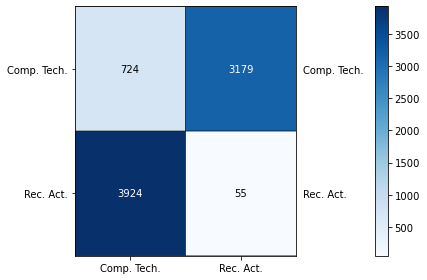

In [4]:
plot_mat(contingency_matrix(y_GT,km.labels_),size=(6,4),xticklabels = ['Comp. Tech.','Rec. Act.'],yticklabels = ['Comp. Tech.','Rec. Act.'],pic_fname = 'Q2.png')

## Question 3

In [5]:
print("Homogeneity: %0.3f" % homogeneity_score(y_GT, km.labels_))
print("Completeness: %0.3f" % completeness_score(y_GT, km.labels_))
print("V-measure: %0.3f" % v_measure_score(y_GT, km.labels_))
print("Adjusted Rand-Index: %.3f"% adjusted_rand_score(y_GT, km.labels_))
print("Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(y_GT, km.labels_))

Homogeneity: 0.581
Completeness: 0.595
V-measure: 0.588
Adjusted Rand-Index: 0.644
Adjusted Mutual Information Score: 0.588


## Question 4

In [6]:
svd = TruncatedSVD(n_components=1000, random_state=0)
LSI = svd.fit_transform(data_feat)

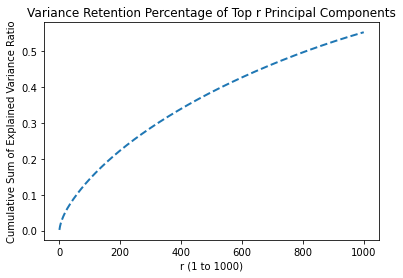

In [7]:
plt.plot(np.linspace(1,1000,1000),np.cumsum(svd.explained_variance_ratio_),lw=2,linestyle='--')
plt.title('Variance Retention Percentage of Top r Principal Components')
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.xlabel('r (1 to 1000)')
plt.savefig('Q4.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 5

In [8]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []

r = [1,2,3,5,10,20,50,100,300]

for i in range(len(r)):
    print('Testing SVD for r = ',r[i])
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(data_feat)
    kmean_svd = km.fit(svd_km)
    svd_hs.append(homogeneity_score(y_GT, kmean_svd.labels_))
    svd_cs.append(completeness_score(y_GT, kmean_svd.labels_))
    svd_vs.append(v_measure_score(y_GT, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(y_GT, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(y_GT, kmean_svd.labels_))    
    print('Testing NMF for r = ',r[i])
    nmf = NMF(n_components=r[i], init='random', random_state=0, max_iter=400)
    nmf_km = nmf.fit_transform(data_feat)
    kmean_nmf = km.fit(nmf_km)
    nmf_hs.append(homogeneity_score(y_GT, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(y_GT, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(y_GT, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(y_GT, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(y_GT, kmean_nmf.labels_))

print('Done testing.')

Testing SVD for r =  1
Testing NMF for r =  1
Testing SVD for r =  2
Testing NMF for r =  2
Testing SVD for r =  3
Testing NMF for r =  3
Testing SVD for r =  5
Testing NMF for r =  5
Testing SVD for r =  10
Testing NMF for r =  10
Testing SVD for r =  20
Testing NMF for r =  20
Testing SVD for r =  50
Testing NMF for r =  50
Testing SVD for r =  100
Testing NMF for r =  100
Testing SVD for r =  300
Testing NMF for r =  300
Done testing.


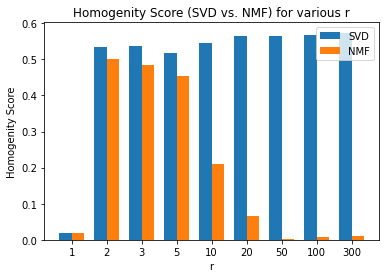

In [9]:
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_hs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_hs, width, label='NMF')
ax.set_ylabel('Homogenity Score')
ax.set_title('Homogenity Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q51.png',dpi=300,bbox_inches='tight')
plt.show()

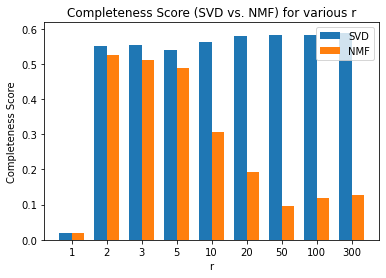

In [10]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_cs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_cs, width, label='NMF')
ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q52.png',dpi=300,bbox_inches='tight')
plt.show()

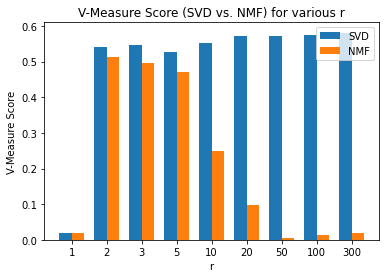

In [11]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_vs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_vs, width, label='NMF')
ax.set_ylabel('V-Measure Score')
ax.set_title('V-Measure Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q53.png',dpi=300,bbox_inches='tight')
plt.show()

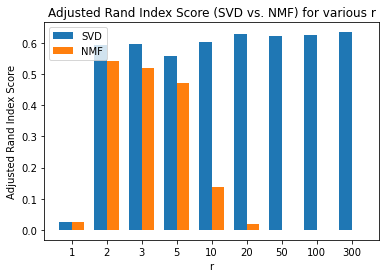

In [12]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ari, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ari, width, label='NMF')
ax.set_ylabel('Adjusted Rand Index Score')
ax.set_title('Adjusted Rand Index Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q54.png',dpi=300,bbox_inches='tight')
plt.show()

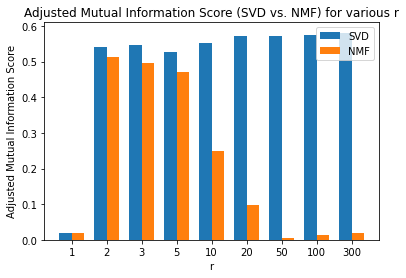

In [13]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ms, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ms, width, label='NMF')
ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q55.png',dpi=300,bbox_inches='tight')
plt.show()

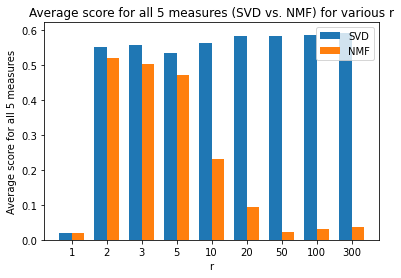

In [14]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]], width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]], width, label='NMF')
ax.set_ylabel('Average score for all 5 measures')
ax.set_title('Average score for all 5 measures (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q56.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 7

In [8]:
#best r for SVD: 20. Best r for NMF: 2
svd = TruncatedSVD(n_components=20, random_state=0)
svd_km = svd.fit_transform(data_feat)
y_svd = km.fit_predict(svd_km)
nmf = NMF(n_components=2, init='random', random_state=0, max_iter=400)
nmf_km = nmf.fit_transform(data_feat)
nmf_svd = km.fit_predict(nmf_km)

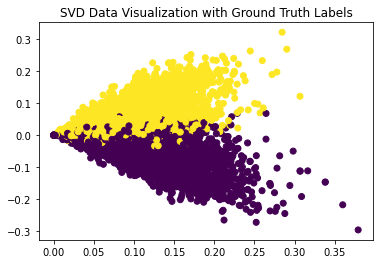

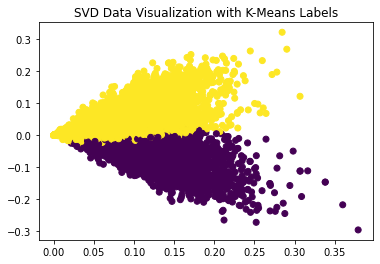

In [9]:
plt.scatter(svd_km[:,0],svd_km[:,1],c=y_GT)
plt.title("SVD Data Visualization with Ground Truth Labels")
plt.savefig('Q71.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(svd_km[:,0],svd_km[:,1],c=y_svd)
plt.title("SVD Data Visualization with K-Means Labels")
plt.savefig('Q72.png',dpi=300,bbox_inches='tight')
plt.show()

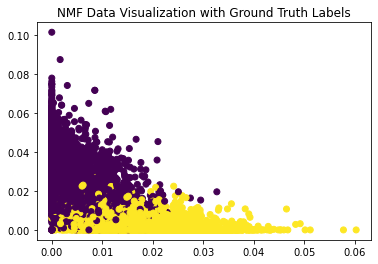

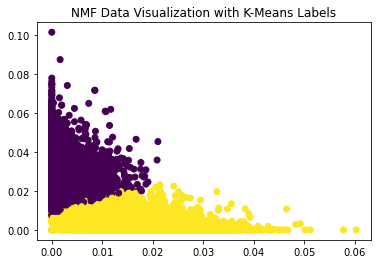

In [10]:
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=y_GT)
plt.title("NMF Data Visualization with Ground Truth Labels")
plt.savefig('Q73.png',dpi=300,bbox_inches='tight')
plt.show()
plt.scatter(nmf_km[:,0],nmf_km[:,1],c=y_svd)
plt.title("NMF Data Visualization with K-Means Labels")
plt.savefig('Q74.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 9

In [2]:
dataset = fetch_20newsgroups(subset = 'all',shuffle = True, random_state = 0,remove=('headers','footers'))
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()
data_feat_vec = vectorizer.fit_transform(dataset.data)
data_feat = tfidf_transformer.fit_transform(data_feat_vec)

In [19]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []

km = KMeans(n_clusters=20, init='k-means++', max_iter=1000, n_init=30, random_state=0,n_jobs=-1)

for i in range(len(r)):
    print('Testing SVD for r = ',r[i])
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(data_feat)
    kmean_svd = km.fit(svd_km)
    svd_hs.append(homogeneity_score(dataset.target, kmean_svd.labels_))
    svd_cs.append(completeness_score(dataset.target, kmean_svd.labels_))
    svd_vs.append(v_measure_score(dataset.target, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(dataset.target, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(dataset.target, kmean_svd.labels_)) 
print('Done testing')

Testing SVD for r =  1
Testing SVD for r =  2
Testing SVD for r =  3
Testing SVD for r =  5
Testing SVD for r =  10
Testing SVD for r =  20
Testing SVD for r =  50
Testing SVD for r =  100
Testing SVD for r =  300
Done testing


In [20]:
print('R: ',r)
print('Homogeneity (SVD, various r): ',svd_hs)
print('Completeness (SVD, various r): ',svd_cs) 
print('V-measure (SVD, various r): ',svd_vs) 
print('Adjusted Rand-Index (SVD, various r): ',svd_ari) 
print('Adjusted Mutual Information Score (SVD, various r): ',svd_ms)

R:  [1, 2, 3, 5, 10, 20, 50, 100, 300]
Homogeneity (SVD, various r):  [0.024187148612053004, 0.2125950892676866, 0.24738131493939977, 0.3214333778771125, 0.3245499574754725, 0.333236617043135, 0.3458766189788096, 0.3209048193470938, 0.32102649871994504]
Completeness (SVD, various r):  [0.026467776667175487, 0.22476838950590647, 0.26593730647544095, 0.34925566861779905, 0.3538692799788343, 0.3755693336566379, 0.43446715637092265, 0.3832675865359189, 0.40179024944743597]
V-measure (SVD, various r):  [0.025276122475778838, 0.21851232739210352, 0.2563239197752381, 0.33476744519160806, 0.338576070454494, 0.3531388360645786, 0.38514315318415665, 0.3493247238641128, 0.3568963152194555]
Adjusted Rand-Index (SVD, various r):  [0.005242558241838782, 0.06556764766862869, 0.08392102022753462, 0.12656215193560497, 0.12266231553925155, 0.12053277796305269, 0.11042604980495854, 0.09564019615748767, 0.10405911055652439]
Adjusted Mutual Information Score (SVD, various r):  [0.021952877952663864, 0.2159

In [21]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]]
best_r_SVD = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for SVD (according to avg. metric): ', best_r_SVD, ', avg. value of 5 metrics: ',max(avg_metrics))

Best value of r for SVD (according to avg. metric):  50 , avg. value of 5 metrics:  0.3317638670407721


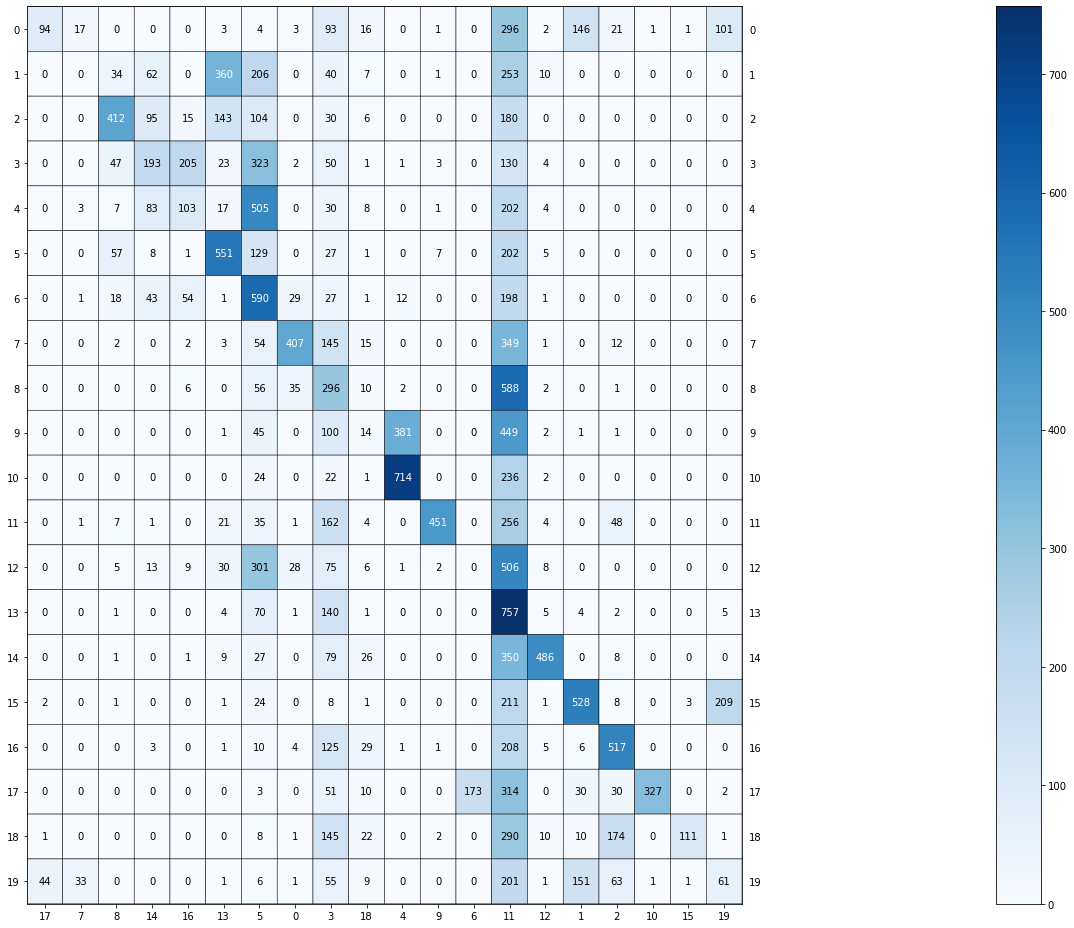

Homogeneity (SVD, best r): 0.346
Completeness (SVD, best r): 0.434
V-measure (SVD, best r): 0.385
Adjusted Rand-Index (SVD, best r): 0.110
Adjusted Mutual Information Score (SVD, best r): 0.383


In [22]:
svd = TruncatedSVD(n_components=best_r_SVD, random_state=0)
svd_km = svd.fit_transform(data_feat)
kmean_svd = km.fit(svd_km)
cm = confusion_matrix(dataset.target, km.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13),pic_fname = 'Q9.png')
print("Homogeneity (SVD, best r): %0.3f" % homogeneity_score(dataset.target, km.labels_))
print("Completeness (SVD, best r): %0.3f" % completeness_score(dataset.target, km.labels_))
print("V-measure (SVD, best r): %0.3f" % v_measure_score(dataset.target, km.labels_))
print("Adjusted Rand-Index (SVD, best r): %.3f"% adjusted_rand_score(dataset.target, km.labels_))
print("Adjusted Mutual Information Score (SVD, best r): %.3f"% adjusted_mutual_info_score(dataset.target, km.labels_))

## Question 10

In [23]:
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []

for i in range(len(r)-1): 
    print('Testing NMF for r = ',r[i])
    nmf = NMF(n_components=r[i], init='random', random_state=0, max_iter=400)
    nmf_km = nmf.fit_transform(data_feat)
    kmean_nmf = km.fit(nmf_km)
    nmf_hs.append(homogeneity_score(dataset.target, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(dataset.target, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(dataset.target, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(dataset.target, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_))
print('Done testing')

Testing NMF for r =  1
Testing NMF for r =  2
Testing NMF for r =  3
Testing NMF for r =  5
Testing NMF for r =  10
Testing NMF for r =  20
Testing NMF for r =  50
Testing NMF for r =  100
Done testing


In [24]:
print('R: ',r[:-1])
print('Homogeneity (NMF, various r): ',nmf_hs)
print('Completeness (NMF, various r): ',nmf_cs) 
print('V-measure (NMF, various r): ',nmf_vs) 
print('Adjusted Rand-Index (NMF, various r): ',nmf_ari) 
print('Adjusted Mutual Information Score (NMF, various r): ',nmf_ms)

R:  [1, 2, 3, 5, 10, 20, 50, 100]
Homogeneity (NMF, various r):  [0.02418293013833349, 0.1910547790262287, 0.21967746007150765, 0.26683550314528043, 0.2888312487267663, 0.311480021698195, 0.25463244447819394, 0.14029330462291845]
Completeness (NMF, various r):  [0.02646303476881646, 0.20464240207954457, 0.2570744662468709, 0.28870335515719603, 0.3206130779777108, 0.3724086260503605, 0.34717245207687336, 0.19268911998670613]
V-measure (NMF, various r):  [0.025271656774071373, 0.19761530167814273, 0.236909229629993, 0.27733903355922124, 0.3038934702081099, 0.33923021621908855, 0.29378747376055575, 0.16236889042723177]
Adjusted Rand-Index (NMF, various r):  [0.0052417481099916625, 0.057633539892422626, 0.06731888280057871, 0.08697997264737248, 0.1018015613260908, 0.0956757455706522, 0.06671757556446743, 0.026550532092819917]
Adjusted Mutual Information Score (NMF, various r):  [0.021948404871629232, 0.19492006697216507, 0.23421564285117952, 0.27490744181415, 0.30152097794928107, 0.3368886

In [25]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]]
best_r_NMF = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for NMF (according to avg. metric): ', best_r_NMF, ', avg. value of 5 metrics: ',max(avg_metrics))

Best value of r for NMF (according to avg. metric):  20 , avg. value of 5 metrics:  0.29113664612512097


In [26]:
nmf_normal = NMF(n_components=best_r_NMF,init='random', random_state=1, max_iter=1000)
nmf_km_normal = nmf_normal.fit_transform(data_feat)
kmean_nmf_normal= km.fit(nmf_km_normal)

nmf_KL = NMF(n_components=best_r_NMF,init='random', random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000,alpha=.1,
          l1_ratio=.5)
nmf_km_KL = nmf_KL.fit_transform(data_feat)
kmean_nmf_KL = km.fit(nmf_km_KL)

print("Homogeneity (NMF Normal, best r): %0.3f" % homogeneity_score(dataset.target, kmean_nmf_normal.labels_))
print("Completeness (NMF Normal, best r): %0.3f" % completeness_score(dataset.target, kmean_nmf_normal.labels_))
print("V-measure (NMF Normal, best r): %0.3f" % v_measure_score(dataset.target, kmean_nmf_normal.labels_))
print("Adjusted Rand-Index (NMF Normal, best r): %.3f"% adjusted_rand_score(dataset.target, kmean_nmf_normal.labels_))
print("Adjusted Mutual Information Score (NMF Normal, best r): %.3f"% adjusted_mutual_info_score(dataset.target, kmean_nmf_normal.labels_))

print("Homogeneity (NMF KL, best r): %0.3f" % homogeneity_score(dataset.target, kmean_nmf_KL.labels_))
print("Completeness (NMF KL, best r): %0.3f" % completeness_score(dataset.target, kmean_nmf_KL.labels_))
print("V-measure (NMF KL, best r): %0.3f" % v_measure_score(dataset.target, kmean_nmf_KL.labels_))
print("Adjusted Rand-Index (NMF KL, best r): %.3f"% adjusted_rand_score(dataset.target, kmean_nmf_KL.labels_))
print("Adjusted Mutual Information Score (NMF KL, best r): %.3f"% adjusted_mutual_info_score(dataset.target, kmean_nmf_KL.labels_))

Homogeneity (NMF Normal, best r): 0.424
Completeness (NMF Normal, best r): 0.456
V-measure (NMF Normal, best r): 0.439
Adjusted Rand-Index (NMF Normal, best r): 0.214
Adjusted Mutual Information Score (NMF Normal, best r): 0.437
Homogeneity (NMF KL, best r): 0.424
Completeness (NMF KL, best r): 0.456
V-measure (NMF KL, best r): 0.439
Adjusted Rand-Index (NMF KL, best r): 0.214
Adjusted Mutual Information Score (NMF KL, best r): 0.437


## Question 11

In [27]:
euc_hs = []
euc_cs = []
euc_vs = []
euc_ari = []
euc_ms = []
cos_hs = []
cos_cs = []
cos_vs = []
cos_ari = []
cos_ms = []

for i in range(len(r)-1):
    print('Testing UMAP (euc) for r = ',r[i])
    Umap_euc = umap.UMAP(n_components=r[i], metric='euclidean').fit_transform(data_feat)
    kmean_euc = km.fit(Umap_euc)
    euc_hs.append(homogeneity_score(dataset.target, kmean_euc.labels_))
    euc_cs.append(completeness_score(dataset.target, kmean_euc.labels_))
    euc_vs.append(v_measure_score(dataset.target, kmean_euc.labels_))
    euc_ari.append(adjusted_rand_score(dataset.target, kmean_euc.labels_))
    euc_ms.append(adjusted_mutual_info_score(dataset.target, kmean_euc.labels_)) 
    
    print('Testing UMAP (cos) for r = ',r[i])
    Umap_cos = umap.UMAP(n_components=r[i], metric='cosine').fit_transform(data_feat)
    kmean_cos = km.fit(Umap_cos)
    cos_hs.append(homogeneity_score(dataset.target, kmean_cos.labels_))
    cos_cs.append(completeness_score(dataset.target, kmean_cos.labels_))
    cos_vs.append(v_measure_score(dataset.target, kmean_cos.labels_))
    cos_ari.append(adjusted_rand_score(dataset.target, kmean_cos.labels_))
    cos_ms.append(adjusted_mutual_info_score(dataset.target, kmean_cos.labels_)) 
print('Done testing')

Testing UMAP (euc) for r =  1
Testing UMAP (cos) for r =  1
Testing UMAP (euc) for r =  2
Testing UMAP (cos) for r =  2
Testing UMAP (euc) for r =  3
Testing UMAP (cos) for r =  3
Testing UMAP (euc) for r =  5
Testing UMAP (cos) for r =  5
Testing UMAP (euc) for r =  10
Testing UMAP (cos) for r =  10
Testing UMAP (euc) for r =  20
Testing UMAP (cos) for r =  20
Testing UMAP (euc) for r =  50
Testing UMAP (cos) for r =  50
Testing UMAP (euc) for r =  100
Testing UMAP (cos) for r =  100
Done testing


In [28]:
print('R: ',r[:-1])
print('Homogeneity (UMAP (euclidean), various r): ',euc_hs)
print('Completeness (UMAP (euclidean), various r): ',euc_cs) 
print('V-measure (UMAP (euclidean), various r): ',euc_vs) 
print('Adjusted Rand-Index (UMAP (euclidean), various r): ',euc_ari) 
print('Adjusted Mutual Information Score (UMAP (euclidean), various r): ',euc_ms)
print('Homogeneity (UMAP (cosine), various r): ',cos_hs)
print('Completeness (UMAP (cosine), various r): ',cos_cs) 
print('V-measure (UMAP (cosine), various r): ',cos_vs) 
print('Adjusted Rand-Index (UMAP (cosine), various r): ',cos_ari) 
print('Adjusted Mutual Information Score (UMAP (cosine), various r): ',cos_ms)

R:  [1, 2, 3, 5, 10, 20, 50, 100]
Homogeneity (UMAP (euclidean), various r):  [0.012620293092117551, 0.008419977534533463, 0.009794116947980226, 0.013679098125032495, 0.013467682294252471, 0.013824941934853181, 0.01458029362754561, 0.011682413554848874]
Completeness (UMAP (euclidean), various r):  [0.014174116763440709, 0.009273328579959345, 0.010247660667052927, 0.014149394821237487, 0.014484819777446695, 0.014565127043529679, 0.015728848995795085, 0.012324864566508007]
V-measure (UMAP (euclidean), various r):  [0.013352151351033468, 0.008826074427056622, 0.010015756979665238, 0.013910272506903899, 0.013957745203043187, 0.014185385446148885, 0.01513280924056315, 0.011995042848723561]
Adjusted Rand-Index (UMAP (euclidean), various r):  [0.0007458948060444592, 0.001044484970607995, 0.0014289351548669924, 0.0021771411090928425, 0.0026508157960271716, 0.002946492750673443, 0.0029617312569419113, 0.0021540715777906656]
Adjusted Mutual Information Score (UMAP (euclidean), various r):  [0.00

In [29]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]]
best_r_euc = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Euclidean UMAP (according to avg. metric): ', best_r_euc, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (euclidean), best r): ',euc_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (euclidean), best r): ',euc_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (euclidean), best r): ',euc_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (euclidean), best r): ',euc_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (euclidean), best r): ',euc_ms[avg_metrics.index(max(avg_metrics))])
avg_metrics = [y/5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]]
best_r_cos = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Cosine UMAP (according to avg. metric): ', best_r_cos, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (cosine), best r): ',cos_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (cosine), best r): ',cos_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (cosine), best r): ',cos_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (cosine), best r): ',cos_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (cosine), best r): ',cos_ms[avg_metrics.index(max(avg_metrics))])

Best value of r for Euclidean UMAP (according to avg. metric):  50 , avg. value of 5 metrics:  0.012047162100510421
Metrics: 
Homogeneity (UMAP (euclidean), best r):  0.01458029362754561
Completeness (UMAP (euclidean), best r):  0.015728848995795085
V-measure (UMAP (euclidean), best r):  0.01513280924056315
Adjusted Rand-Index (UMAP (euclidean), best r):  0.0029617312569419113
Adjusted Mutual Information Score (UMAP (euclidean), best r):  0.011832127381706347
Best value of r for Cosine UMAP (according to avg. metric):  5 , avg. value of 5 metrics:  0.539873473448545
Metrics: 
Homogeneity (UMAP (cosine), best r):  0.5607289493767216
Completeness (UMAP (cosine), best r):  0.5660120297949187
V-measure (UMAP (cosine), best r):  0.5633581038914941
Adjusted Rand-Index (UMAP (cosine), best r):  0.44732645053169007
Adjusted Mutual Information Score (UMAP (cosine), best r):  0.5619418336479003


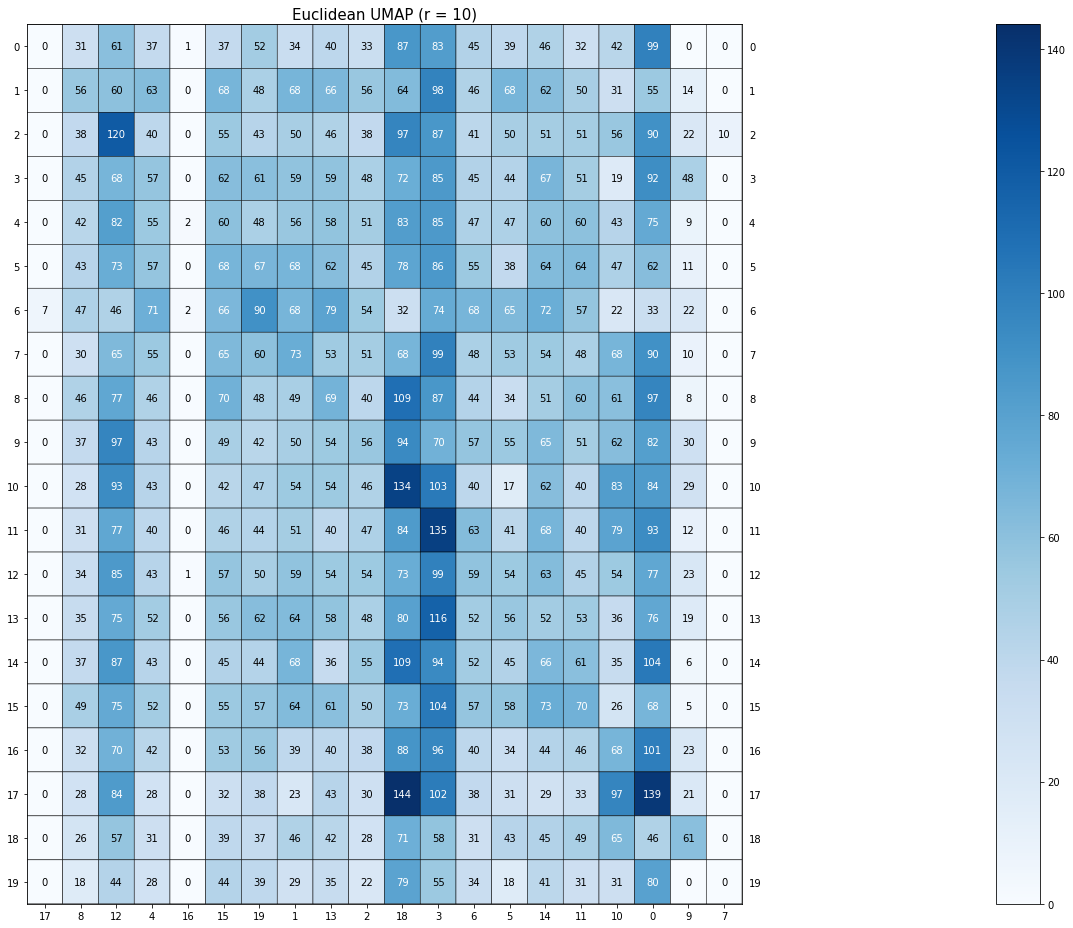

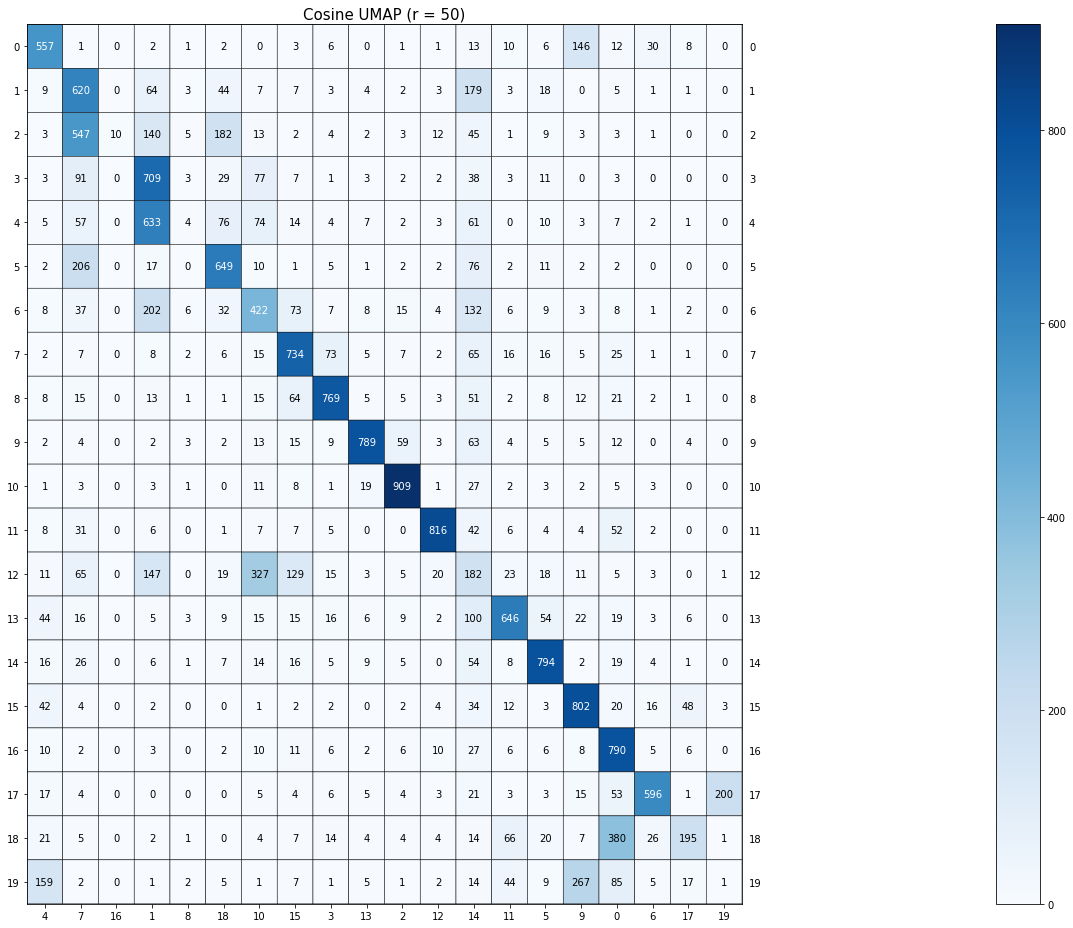

In [13]:
Umap_euc = umap.UMAP(n_components=best_r_euc, metric='euclidean').fit_transform(data_feat)
kmean_euc = km.fit(Umap_euc)
cm = confusion_matrix(dataset.target, kmean_euc.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Euclidean UMAP (r = 10)', size=(15,13),pic_fname = 'Q111.png')

Umap_cos = umap.UMAP(n_components=best_r_cos, metric='cosine').fit_transform(data_feat)
kmean_cos = km.fit(Umap_cos)
cm = confusion_matrix(dataset.target, kmean_cos.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Cosine UMAP (r = 50)', size=(15,13),pic_fname = 'Q112.png')

## Question 13

In [31]:
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(Umap_cos)
ac_s = AgglomerativeClustering(n_clusters=20, linkage='single').fit(Umap_cos)
print("Agglomerative Clustering, Ward - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Completeness: %0.3f" % completeness_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - V-measure: %0.3f" % v_measure_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_w.labels_))
print()
print("Agglomerative Clustering, Single - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Completeness: %0.3f" % completeness_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - V-measure: %0.3f" % v_measure_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_s.labels_))

Agglomerative Clustering, Ward - Homogeneity: 0.539
Agglomerative Clustering, Ward - Completeness: 0.560
Agglomerative Clustering, Ward - V-measure: 0.550
Agglomerative Clustering, Ward - Adjusted Rand-Index: 0.406
Agglomerative Clustering, Ward - Adjusted Mutual Information Score: 0.548

Agglomerative Clustering, Single - Homogeneity: 0.016
Agglomerative Clustering, Single - Completeness: 0.410
Agglomerative Clustering, Single - V-measure: 0.032
Agglomerative Clustering, Single - Adjusted Rand-Index: 0.000
Agglomerative Clustering, Single - Adjusted Mutual Information Score: 0.027


## Question 14

In [32]:
eps_rec = []
min_samples_rec = []
db_hs = []
db_cs = []
db_vs = []
db_ari = []
db_ms = []

eps = [0.01,0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,3.0,5.0,10.0,30.0,50.0]
min_samples = [5,15,30,60,100,200,500,1000,3000]

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        dbs = DBSCAN(eps=eps[i],min_samples=min_samples[j],n_jobs=-1).fit_predict(Umap_cos)
        db_hs.append(homogeneity_score(dataset.target, dbs))
        db_cs.append(completeness_score(dataset.target, dbs))
        db_vs.append(v_measure_score(dataset.target, dbs))
        db_ari.append(adjusted_rand_score(dataset.target, dbs))
        db_ms.append(adjusted_mutual_info_score(dataset.target, dbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])
print('Done testing')

Testing for e and min_sample =  0.01 and 5
Testing for e and min_sample =  0.01 and 15
Testing for e and min_sample =  0.01 and 30
Testing for e and min_sample =  0.01 and 60
Testing for e and min_sample =  0.01 and 100
Testing for e and min_sample =  0.01 and 200
Testing for e and min_sample =  0.01 and 500
Testing for e and min_sample =  0.01 and 1000
Testing for e and min_sample =  0.01 and 3000
Testing for e and min_sample =  0.05 and 5
Testing for e and min_sample =  0.05 and 15
Testing for e and min_sample =  0.05 and 30
Testing for e and min_sample =  0.05 and 60
Testing for e and min_sample =  0.05 and 100
Testing for e and min_sample =  0.05 and 200
Testing for e and min_sample =  0.05 and 500
Testing for e and min_sample =  0.05 and 1000
Testing for e and min_sample =  0.05 and 3000
Testing for e and min_sample =  0.1 and 5
Testing for e and min_sample =  0.1 and 15
Testing for e and min_sample =  0.1 and 30
Testing for e and min_sample =  0.1 and 60
Testing for e and min_sam

In [33]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(db_hs, db_cs, db_vs, db_ari, db_ms)]]
best_eps_db = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_db = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for DBSCAN: ', best_eps_db,'and',best_minSample_db, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (DBSCAN, best hyperparameters): ',db_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (DBSCAN, best hyperparameters): ',db_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (DBSCAN, best hyperparameters): ',db_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (DBSCAN, best hyperparameters): ',db_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (DBSCAN, best hyperparameters): ',db_ms[avg_metrics.index(max(avg_metrics))])


Best value of epsilon and minimum number of samples hyperparameters for DBSCAN:  0.5 and 60  respectively, avg. value of 5 metrics:  0.47767964522835094
Metrics: 
Homogeneity (DBSCAN, best hyperparameters):  0.46122031931292645
Completeness (DBSCAN, best hyperparameters):  0.5851789552890995
V-measure (DBSCAN, best hyperparameters):  0.515857438292457
Adjusted Rand-Index (DBSCAN, best hyperparameters):  0.311695108903137
Adjusted Mutual Information Score (DBSCAN, best hyperparameters):  0.5144464043441347


In [34]:
eps_rec = []
min_samples_rec = []
hdb_hs = []
hdb_cs = []
hdb_vs = []
hdb_ari = []
hdb_ms = []

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=eps[i],min_samples=min_samples[j],core_dist_n_jobs=-1).fit_predict(Umap_cos)
        hdb_hs.append(homogeneity_score(dataset.target, hdbs))
        hdb_cs.append(completeness_score(dataset.target, hdbs))
        hdb_vs.append(v_measure_score(dataset.target, hdbs))
        hdb_ari.append(adjusted_rand_score(dataset.target, hdbs))
        hdb_ms.append(adjusted_mutual_info_score(dataset.target, hdbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])
print('Done testing')

Testing for e and min_sample =  0.01 and 5
Testing for e and min_sample =  0.01 and 15
Testing for e and min_sample =  0.01 and 30
Testing for e and min_sample =  0.01 and 60
Testing for e and min_sample =  0.01 and 100
Testing for e and min_sample =  0.01 and 200
Testing for e and min_sample =  0.01 and 500
Testing for e and min_sample =  0.01 and 1000
Testing for e and min_sample =  0.01 and 3000
Testing for e and min_sample =  0.05 and 5
Testing for e and min_sample =  0.05 and 15
Testing for e and min_sample =  0.05 and 30
Testing for e and min_sample =  0.05 and 60
Testing for e and min_sample =  0.05 and 100
Testing for e and min_sample =  0.05 and 200
Testing for e and min_sample =  0.05 and 500
Testing for e and min_sample =  0.05 and 1000
Testing for e and min_sample =  0.05 and 3000
Testing for e and min_sample =  0.1 and 5
Testing for e and min_sample =  0.1 and 15
Testing for e and min_sample =  0.1 and 30
Testing for e and min_sample =  0.1 and 60
Testing for e and min_sam

In [35]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(hdb_hs, hdb_cs, hdb_vs, hdb_ari, hdb_ms)]]
best_eps_hdb = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_hdb = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN: ', best_eps_hdb,'and',best_minSample_hdb, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (HDBSCAN, best hyperparameters): ',hdb_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (HDBSCAN, best hyperparameters): ',hdb_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (HDBSCAN, best hyperparameters): ',hdb_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (HDBSCAN, best hyperparameters): ',hdb_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (HDBSCAN, best hyperparameters): ',hdb_ms[avg_metrics.index(max(avg_metrics))])


Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN:  0.4 and 30  respectively, avg. value of 5 metrics:  0.4595878354145637
Metrics: 
Homogeneity (HDBSCAN, best hyperparameters):  0.4419241631830412
Completeness (HDBSCAN, best hyperparameters):  0.5742278618978046
V-measure (HDBSCAN, best hyperparameters):  0.49946299585514187
Adjusted Rand-Index (HDBSCAN, best hyperparameters):  0.2839171766231235
Adjusted Mutual Information Score (HDBSCAN, best hyperparameters):  0.4984069795137075


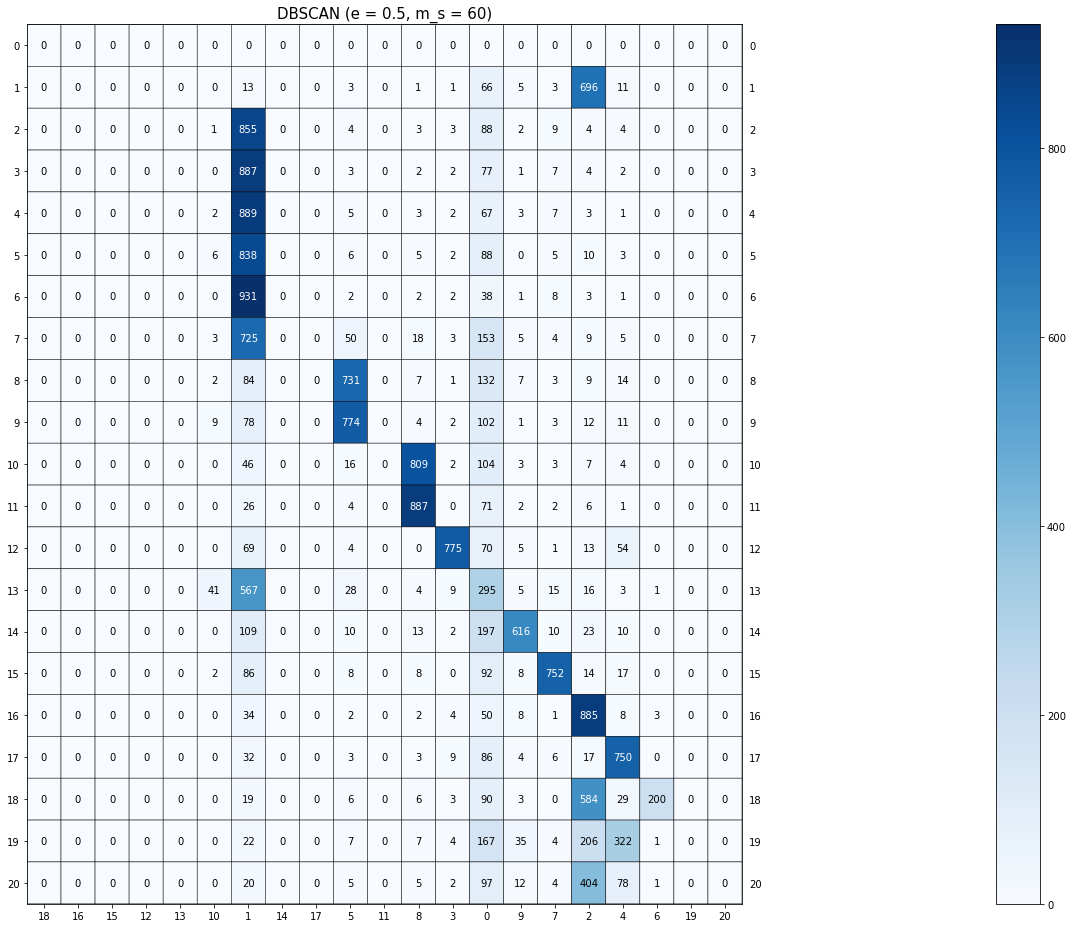

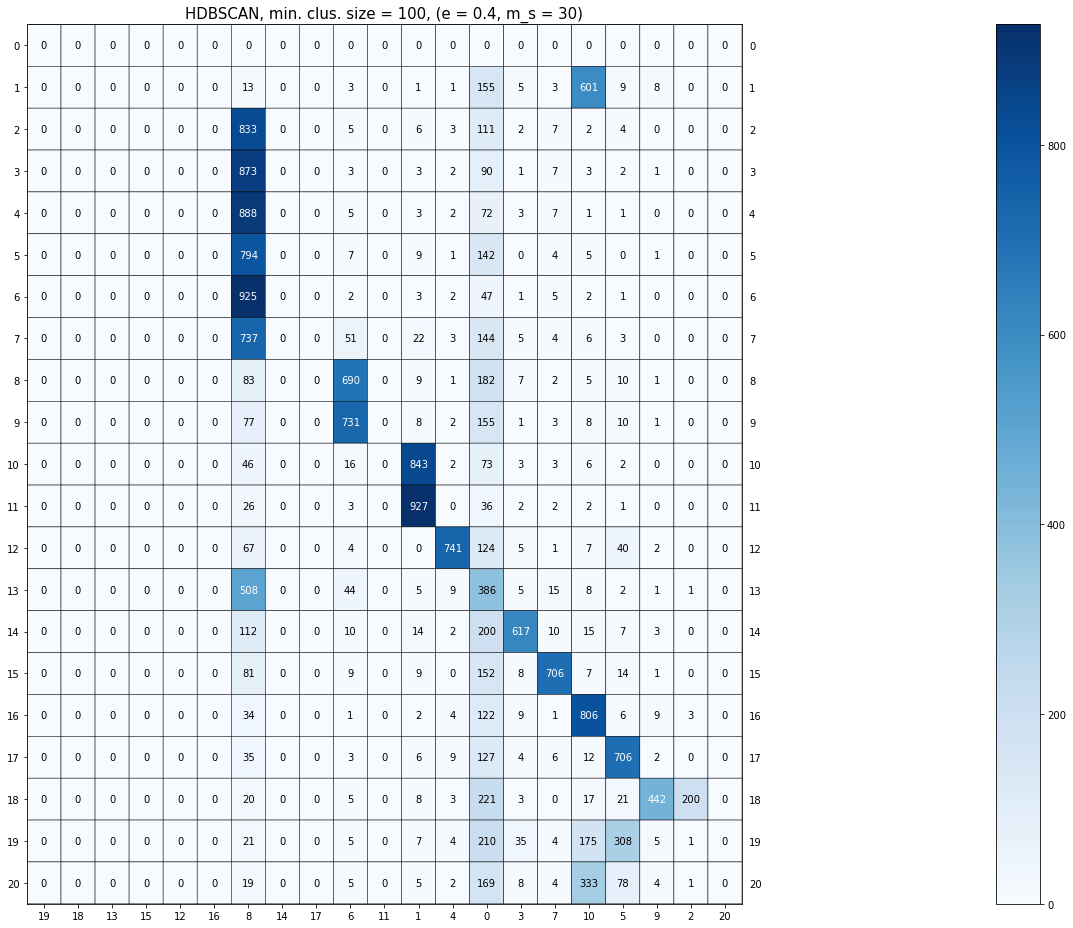

In [15]:
dbs = DBSCAN(eps=best_eps_db,min_samples=best_minSample_db ,n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, dbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'DBSCAN (e = 0.5, m_s = 60)', size=(15,13),pic_fname = 'Q151.png')

hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=best_eps_hdb,min_samples=best_minSample_hdb,core_dist_n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, hdbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN, min. clus. size = 100, (e = 0.4, m_s = 30)', size=(15,13),pic_fname = 'Q152.png')

## Question 16

#### Step 1: Dataset Acquiring and Preprocessing

In [2]:
#dataset downloaded and stored in the project directory inside "learn-ai-bbc" folder
BBC_dataset_train = pd.read_csv("learn-ai-bbc/BBC News Train.csv",usecols=['Text','Category']) 
BBC_dataset_labels = BBC_dataset_train.pop('Category').values
X_BBC=["".join(text) for text in BBC_dataset_train['Text'].values]
y_GT = pd.factorize(BBC_dataset_labels)[0]
print('Size of training set: ',BBC_dataset_train.shape)
print('Size of training set (list): ',len(X_BBC))
print('Size of labels: ',BBC_dataset_labels.shape)
print('Size of labels (factorized to int): ',y_GT.shape)
print('Name of all unique lables ',set(BBC_dataset_labels))
print('Name of all unique lables (factorized to int) ',set(y_GT))

Size of training set:  (1490, 1)
Size of training set (list):  1490
Size of labels:  (1490,)
Size of labels (factorized to int):  (1490,)
Name of all unique lables  {'politics', 'sport', 'business', 'entertainment', 'tech'}
Name of all unique lables (factorized to int)  {0, 1, 2, 3, 4}


#### Step 2: Feature Extraction

In [20]:
tfidf_transformer = TfidfVectorizer(min_df=3, stop_words='english')
data_feat = tfidf_transformer.fit_transform(X_BBC)
print(data_feat.shape)

(1490, 10281)


#### Step 3 and 4: Testing out various dimensionality reduction schemes and clustering

##### a. K-means with SVD, NMF, UMAP (Euclidean) and UMAP (Cosine)

In [39]:
svd_hs = []
svd_cs = []
svd_vs = []
svd_ari = []
svd_ms = []
nmf_hs = []
nmf_cs = []
nmf_vs = []
nmf_ari = []
nmf_ms = []
cos_hs = []
cos_cs = []
cos_vs = []
cos_ari = []
cos_ms = []
euc_hs = []
euc_cs = []
euc_vs = []
euc_ari = []
euc_ms = []

r = [1,2,3,5,10,20,50,100]
km = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=30, random_state=0,n_jobs=-1)

for i in range(len(r)):
    print('Testing SVD for r = ',r[i])
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(data_feat)
    kmean_svd = km.fit(svd_km)
    svd_hs.append(homogeneity_score(y_GT, kmean_svd.labels_))
    svd_cs.append(completeness_score(y_GT, kmean_svd.labels_))
    svd_vs.append(v_measure_score(y_GT, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(y_GT, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(y_GT, kmean_svd.labels_))    
    print('Testing NMF for r = ',r[i])
    nmf = NMF(n_components=r[i], init='random', random_state=0, max_iter=400)
    nmf_km = nmf.fit_transform(data_feat)
    kmean_nmf = km.fit(nmf_km)
    nmf_hs.append(homogeneity_score(y_GT, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(y_GT, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(y_GT, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(y_GT, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(y_GT, kmean_nmf.labels_))
    print('Testing UMAP (cos) for r = ',r[i])
    Umap_cos = umap.UMAP(n_components=r[i], metric='cosine').fit_transform(data_feat)
    kmean_cos = km.fit(Umap_cos)
    cos_hs.append(homogeneity_score(y_GT, kmean_cos.labels_))
    cos_cs.append(completeness_score(y_GT, kmean_cos.labels_))
    cos_vs.append(v_measure_score(y_GT, kmean_cos.labels_))
    cos_ari.append(adjusted_rand_score(y_GT, kmean_cos.labels_))
    cos_ms.append(adjusted_mutual_info_score(y_GT, kmean_cos.labels_))
    print('Testing UMAP (euc) for r = ',r[i])
    Umap_euc = umap.UMAP(n_components=r[i], metric='euclidean').fit_transform(data_feat)
    kmean_euc = km.fit(Umap_euc)
    euc_hs.append(homogeneity_score(y_GT, kmean_euc.labels_))
    euc_cs.append(completeness_score(y_GT, kmean_euc.labels_))
    euc_vs.append(v_measure_score(y_GT, kmean_euc.labels_))
    euc_ari.append(adjusted_rand_score(y_GT, kmean_euc.labels_))
    euc_ms.append(adjusted_mutual_info_score(y_GT, kmean_euc.labels_)) 
print('Done testing.')

Testing SVD for r =  1
Testing NMF for r =  1
Testing UMAP (cos) for r =  1
Testing UMAP (euc) for r =  1
Testing SVD for r =  2
Testing NMF for r =  2
Testing UMAP (cos) for r =  2
Testing UMAP (euc) for r =  2
Testing SVD for r =  3
Testing NMF for r =  3
Testing UMAP (cos) for r =  3
Testing UMAP (euc) for r =  3
Testing SVD for r =  5
Testing NMF for r =  5
Testing UMAP (cos) for r =  5
Testing UMAP (euc) for r =  5
Testing SVD for r =  10
Testing NMF for r =  10
Testing UMAP (cos) for r =  10
Testing UMAP (euc) for r =  10
Testing SVD for r =  20
Testing NMF for r =  20
Testing UMAP (cos) for r =  20
Testing UMAP (euc) for r =  20
Testing SVD for r =  50
Testing NMF for r =  50
Testing UMAP (cos) for r =  50
Testing UMAP (euc) for r =  50
Testing SVD for r =  100
Testing NMF for r =  100
Testing UMAP (cos) for r =  100
Testing UMAP (euc) for r =  100
Done testing.


##### b. Performance Evaluation of K-Means

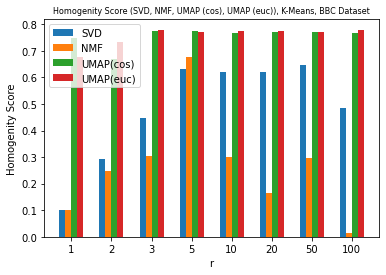

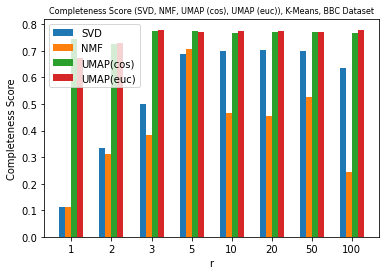

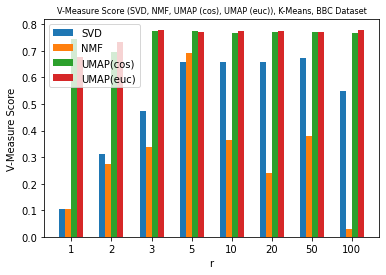

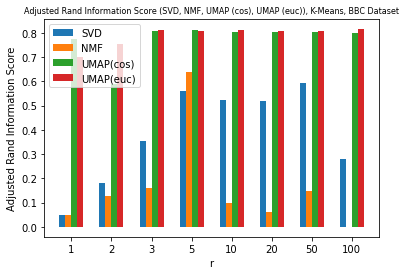

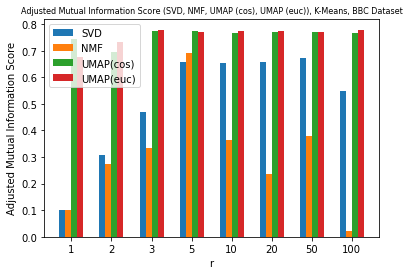

In [40]:
width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, svd_hs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, nmf_hs, width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, cos_hs, width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, euc_hs, width, label='UMAP(euc)')
ax.set_ylabel('Homogenity Score')
ax.set_title('Homogenity Score (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q161.png',dpi=300,bbox_inches='tight')
plt.show()

width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, svd_cs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, nmf_cs, width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, cos_cs, width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, euc_cs, width, label='UMAP(euc)')
ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q162.png',dpi=300,bbox_inches='tight')
plt.show()

width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, svd_vs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, nmf_vs, width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, cos_vs, width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, euc_vs, width, label='UMAP(euc)')
ax.set_ylabel('V-Measure Score')
ax.set_title('V-Measure Score (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q163.png',dpi=300,bbox_inches='tight')
plt.show()

width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, svd_ari, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, nmf_ari, width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, cos_ari, width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, euc_ari, width, label='UMAP(euc)')
ax.set_ylabel('Adjusted Rand Information Score')
ax.set_title('Adjusted Rand Information Score (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q164.png',dpi=300,bbox_inches='tight')
plt.show()

width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, svd_ms, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, nmf_ms, width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, cos_ms, width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, euc_ms, width, label='UMAP(euc)')
ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information Score (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q165.png',dpi=300,bbox_inches='tight')
plt.show()

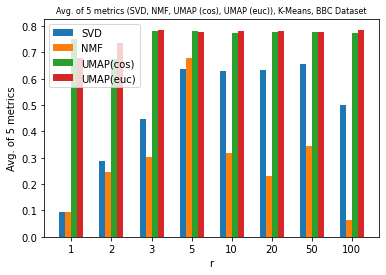

In [41]:
width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - 1.5*width, [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]], width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) - width/2, [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]], width, label='NMF')
rects3 = ax.bar(np.arange(len(r)) + width/2, [y/5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]], width, label='UMAP(cos)')
rects4 = ax.bar(np.arange(len(r)) + 1.5*width, [y/5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]], width, label='UMAP(euc)')
ax.set_ylabel('Avg. of 5 metrics')
ax.set_title('Avg. of 5 metrics (SVD, NMF, UMAP (cos), UMAP (euc)), K-Means, BBC Dataset',fontsize=8)
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.savefig('Q166.png',dpi=300,bbox_inches='tight')
plt.show()

In [42]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]]
best_r_euc = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Euclidean UMAP (according to avg. metric): ', best_r_euc, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (euclidean), best r): ',euc_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (euclidean), best r): ',euc_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (euclidean), best r): ',euc_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (euclidean), best r): ',euc_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (euclidean), best r): ',euc_ms[avg_metrics.index(max(avg_metrics))])
print('--------------------------------------------------------------------------------------------------------')
avg_metrics = [y/5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]]
best_r_cos = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Cosine UMAP (according to avg. metric): ', best_r_cos, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (cosine), best r): ',cos_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (cosine), best r): ',cos_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (UMAP (cosine), best r): ',cos_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (UMAP (cosine), best r): ',cos_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (UMAP (cosine), best r): ',cos_ms[avg_metrics.index(max(avg_metrics))])
print('--------------------------------------------------------------------------------------------------------')
avg_metrics = [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]]
best_r_NMF = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for NMF (according to avg. metric): ', best_r_NMF, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (NMF, best r): ',nmf_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (NMF, best r): ',nmf_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (NMF, best r): ',nmf_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (NMF, best r): ',nmf_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (NMF, best r): ',nmf_ms[avg_metrics.index(max(avg_metrics))])
print('--------------------------------------------------------------------------------------------------------')
avg_metrics = [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]]
best_r_svd = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for SVD (according to avg. metric): ', best_r_svd, ', avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (SVD, best r): ',svd_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (SVD, best r): ',svd_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (SVD, best r): ',svd_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (SVD, best r): ',svd_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (SVD, best r): ',svd_ms[avg_metrics.index(max(avg_metrics))])

Best value of r for Euclidean UMAP (according to avg. metric):  100 , avg. value of 5 metrics:  0.7863568934147168
Metrics: 
Homogeneity (UMAP (euclidean), best r):  0.7792623218537925
Completeness (UMAP (euclidean), best r):  0.7797694659206051
V-measure (UMAP (euclidean), best r):  0.7795158114016759
Adjusted Rand-Index (UMAP (euclidean), best r):  0.8144656785590599
Adjusted Mutual Information Score (UMAP (euclidean), best r):  0.7787711893384506
--------------------------------------------------------------------------------------------------------
Best value of r for Cosine UMAP (according to avg. metric):  5 , avg. value of 5 metrics:  0.782891909150627
Metrics: 
Homogeneity (UMAP (cosine), best r):  0.7759972871042146
Completeness (UMAP (cosine), best r):  0.7762459012114491
V-measure (UMAP (cosine), best r):  0.7761215742482664
Adjusted Rand-Index (UMAP (cosine), best r):  0.8107291656585696
Adjusted Mutual Information Score (UMAP (cosine), best r):  0.7753656175306356
--------

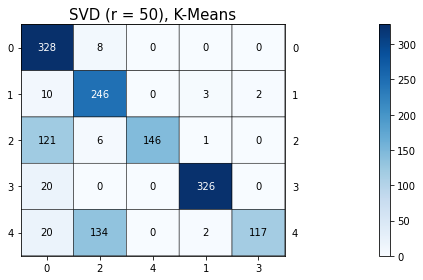

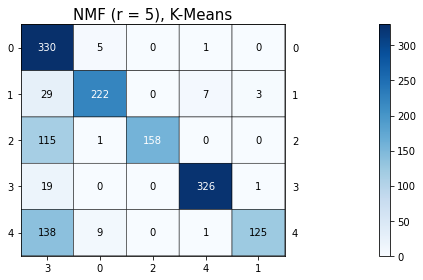

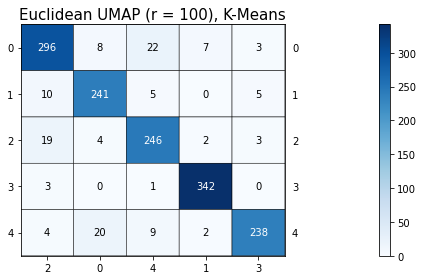

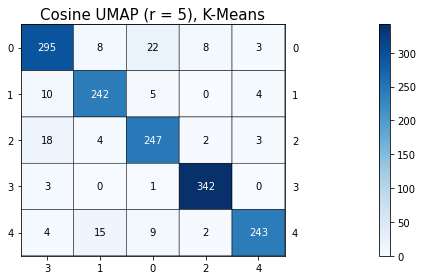

In [21]:
svd = TruncatedSVD(n_components=best_r_SVD, random_state=0)
svd_km = svd.fit_transform(data_feat)
kmean_svd = km.fit(svd_km)
cm = confusion_matrix(y_GT, kmean_svd.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,title = 'SVD (r = 50), K-Means', size=(6,4),pic_fname = 'Q167.png')

nmf_normal = NMF(n_components=best_r_NMF,init='random', random_state=1, max_iter=1000)
nmf_km_normal = nmf_normal.fit_transform(data_feat)
kmean_nmf_normal= km.fit(nmf_km_normal)
cm = confusion_matrix(y_GT, kmean_nmf_normal.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,title = 'NMF (r = 5), K-Means', size=(6,4),pic_fname = 'Q168.png')


Umap_euc = umap.UMAP(n_components=best_r_euc, metric='euclidean').fit_transform(data_feat)
kmean_euc = km.fit(Umap_euc)
cm = confusion_matrix(y_GT, kmean_euc.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Euclidean UMAP (r = 100), K-Means', size=(6,4),pic_fname = 'Q169.png')

Umap_cos = umap.UMAP(n_components=best_r_cos, metric='cosine').fit_transform(data_feat)
kmean_cos = km.fit(Umap_cos)
cm = confusion_matrix(y_GT, kmean_cos.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'Cosine UMAP (r = 5), K-Means', size=(6,4),pic_fname = 'Q1610.png')



##### b. Agglomerative clustering, DBSCAN and HDBSCAN with UMAP (Cosine)

In [44]:
Umap_cos = umap.UMAP(n_components=10, metric='cosine').fit_transform(data_feat)
ac_w = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(Umap_cos)
ac_s = AgglomerativeClustering(n_clusters=5, linkage='single').fit(Umap_cos)

In [45]:
eps_rec = []
min_samples_rec = []
db_hs = []
db_cs = []
db_vs = []
db_ari = []
db_ms = []

eps = [0.01,0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,3.0,5.0,10.0,30.0,50.0]
min_samples = [5,15,30,60,100,200,500,1000,3000]

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        dbs = DBSCAN(eps=eps[i],min_samples=min_samples[j],n_jobs=-1).fit_predict(Umap_cos)
        db_hs.append(homogeneity_score(y_GT, dbs))
        db_cs.append(completeness_score(y_GT, dbs))
        db_vs.append(v_measure_score(y_GT, dbs))
        db_ari.append(adjusted_rand_score(y_GT, dbs))
        db_ms.append(adjusted_mutual_info_score(y_GT, dbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])
print('Done testing')

Testing for e and min_sample =  0.01 and 5
Testing for e and min_sample =  0.01 and 15
Testing for e and min_sample =  0.01 and 30
Testing for e and min_sample =  0.01 and 60
Testing for e and min_sample =  0.01 and 100
Testing for e and min_sample =  0.01 and 200
Testing for e and min_sample =  0.01 and 500
Testing for e and min_sample =  0.01 and 1000
Testing for e and min_sample =  0.01 and 3000
Testing for e and min_sample =  0.05 and 5
Testing for e and min_sample =  0.05 and 15
Testing for e and min_sample =  0.05 and 30
Testing for e and min_sample =  0.05 and 60
Testing for e and min_sample =  0.05 and 100
Testing for e and min_sample =  0.05 and 200
Testing for e and min_sample =  0.05 and 500
Testing for e and min_sample =  0.05 and 1000
Testing for e and min_sample =  0.05 and 3000
Testing for e and min_sample =  0.1 and 5
Testing for e and min_sample =  0.1 and 15
Testing for e and min_sample =  0.1 and 30
Testing for e and min_sample =  0.1 and 60
Testing for e and min_sam

In [46]:
hdb_hs = []
hdb_cs = []
hdb_vs = []
hdb_ari = []
hdb_ms = []

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print('Testing for e and min_sample = ',eps[i],'and',min_samples[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=eps[i],min_samples=min_samples[j],core_dist_n_jobs=-1).fit_predict(Umap_cos)
        hdb_hs.append(homogeneity_score(y_GT, hdbs))
        hdb_cs.append(completeness_score(y_GT, hdbs))
        hdb_vs.append(v_measure_score(y_GT, hdbs))
        hdb_ari.append(adjusted_rand_score(y_GT, hdbs))
        hdb_ms.append(adjusted_mutual_info_score(y_GT, hdbs)) 
print('Done testing')

Testing for e and min_sample =  0.01 and 5
Testing for e and min_sample =  0.01 and 15
Testing for e and min_sample =  0.01 and 30
Testing for e and min_sample =  0.01 and 60
Testing for e and min_sample =  0.01 and 100
Testing for e and min_sample =  0.01 and 200
Testing for e and min_sample =  0.01 and 500
Testing for e and min_sample =  0.01 and 1000
Testing for e and min_sample =  0.01 and 3000
Testing for e and min_sample =  0.05 and 5
Testing for e and min_sample =  0.05 and 15
Testing for e and min_sample =  0.05 and 30
Testing for e and min_sample =  0.05 and 60
Testing for e and min_sample =  0.05 and 100
Testing for e and min_sample =  0.05 and 200
Testing for e and min_sample =  0.05 and 500
Testing for e and min_sample =  0.05 and 1000
Testing for e and min_sample =  0.05 and 3000
Testing for e and min_sample =  0.1 and 5
Testing for e and min_sample =  0.1 and 15
Testing for e and min_sample =  0.1 and 30
Testing for e and min_sample =  0.1 and 60
Testing for e and min_sam

##### Performance Evaluation of  Agglomerative clustering, DBSCAN and HDBSCAN

In [47]:
print("Agglomerative Clustering, Ward - Homogeneity: %0.3f" % homogeneity_score(y_GT, ac_w.labels_))
print("Agglomerative Clustering, Ward - Completeness: %0.3f" % completeness_score(y_GT, ac_w.labels_))
print("Agglomerative Clustering, Ward - V-measure: %0.3f" % v_measure_score(y_GT, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Rand-Index: %.3f"% adjusted_rand_score(y_GT, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(y_GT, ac_w.labels_))
print("------------------------------------------------------------------------------------------------")
print("Agglomerative Clustering, Single - Homogeneity: %0.3f" % homogeneity_score(y_GT, ac_s.labels_))
print("Agglomerative Clustering, Single - Completeness: %0.3f" % completeness_score(y_GT, ac_s.labels_))
print("Agglomerative Clustering, Single - V-measure: %0.3f" % v_measure_score(y_GT, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Rand-Index: %.3f"% adjusted_rand_score(y_GT, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(y_GT, ac_s.labels_))

Agglomerative Clustering, Ward - Homogeneity: 0.764
Agglomerative Clustering, Ward - Completeness: 0.768
Agglomerative Clustering, Ward - V-measure: 0.766
Agglomerative Clustering, Ward - Adjusted Rand-Index: 0.793
Agglomerative Clustering, Ward - Adjusted Mutual Information Score: 0.765
------------------------------------------------------------------------------------------------
Agglomerative Clustering, Single - Homogeneity: 0.316
Agglomerative Clustering, Single - Completeness: 0.633
Agglomerative Clustering, Single - V-measure: 0.422
Agglomerative Clustering, Single - Adjusted Rand-Index: 0.168
Agglomerative Clustering, Single - Adjusted Mutual Information Score: 0.419


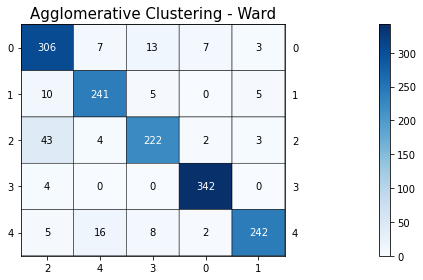

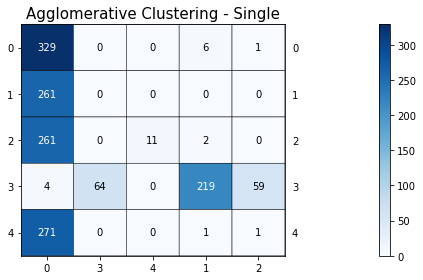

In [48]:
cm = confusion_matrix(y_GT, ac_w.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,title = 'Agglomerative Clustering - Ward', size=(6,4),pic_fname = 'Q1611.png')

cm = confusion_matrix(y_GT, ac_s.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,title = 'Agglomerative Clustering - Single', size=(6,4),pic_fname = 'Q1612.png')


In [49]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(db_hs, db_cs, db_vs, db_ari, db_ms)]]
best_eps_db = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_db = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for DBSCAN: ', best_eps_db,'and',best_minSample_db, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (DBSCAN, best hyperparameters): ',db_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (DBSCAN, best hyperparameters): ',db_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (DBSCAN, best hyperparameters): ',db_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (DBSCAN, best hyperparameters): ',db_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (DBSCAN, best hyperparameters): ',db_ms[avg_metrics.index(max(avg_metrics))])
print("------------------------------------------------------------------------------------------------")
avg_metrics = [y/5 for y in [sum(x) for x in zip(hdb_hs, hdb_cs, hdb_vs, hdb_ari, hdb_ms)]]
best_eps_hdb = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_hdb = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN: ', best_eps_hdb,'and',best_minSample_hdb, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (HDBSCAN, best hyperparameters): ',hdb_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (HDBSCAN, best hyperparameters): ',hdb_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (HDBSCAN, best hyperparameters): ',hdb_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (HDBSCAN, best hyperparameters): ',hdb_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (HDBSCAN, best hyperparameters): ',hdb_ms[avg_metrics.index(max(avg_metrics))])

Best value of epsilon and minimum number of samples hyperparameters for DBSCAN:  0.7 and 30  respectively, avg. value of 5 metrics:  0.7100000647110825
Metrics: 
Homogeneity (DBSCAN, best hyperparameters):  0.7812601834858268
Completeness (DBSCAN, best hyperparameters):  0.6508983166825818
V-measure (DBSCAN, best hyperparameters):  0.7101461720364782
Adjusted Rand-Index (DBSCAN, best hyperparameters):  0.6991186381134069
Adjusted Mutual Information Score (DBSCAN, best hyperparameters):  0.708577013237118
------------------------------------------------------------------------------------------------
Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN:  0.01 and 15  respectively, avg. value of 5 metrics:  0.653956470738123
Metrics: 
Homogeneity (HDBSCAN, best hyperparameters):  0.5631797605582871
Completeness (HDBSCAN, best hyperparameters):  0.8104923940615928
V-measure (HDBSCAN, best hyperparameters):  0.6645732912133311
Adjusted Rand-Index (HDBSCAN, best h

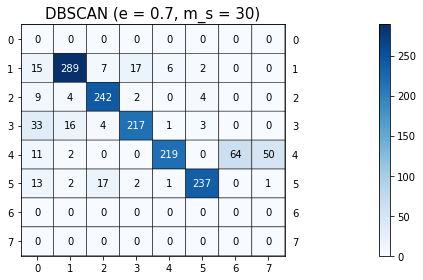

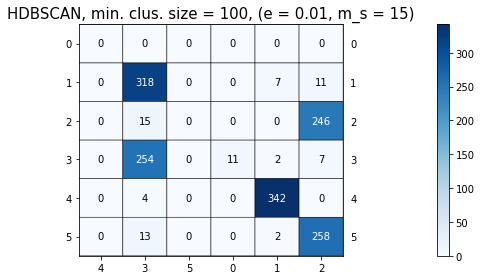

In [52]:
dbs = DBSCAN(eps=best_eps_db,min_samples=best_minSample_db,n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(y_GT, dbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'DBSCAN (e = 0.7, m_s = 30)', size=(6,4),pic_fname = 'Q1613.png')

hdbs = hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=best_eps_hdb,min_samples=best_minSample_db,core_dist_n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(y_GT, hdbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN, min. clus. size = 100, (e = 0.01, m_s = 15)', size=(6,4),pic_fname = 'Q1614.png')